<a href="https://colab.research.google.com/github/Nadian-Ali/MVIP2022_Workshop_GANs/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Develop a DCGAN for
Grayscale Handwritten Digits</h1>
<p>
Developing a GAN for gener-
ating images requires both a discriminator convolutional neural network model for classifying
whether a given image is real or generated and a generator model that uses inverse convolutional
layers to transform an input to a full two-dimensional image of pixel values.
</p>

What we are going to see:
<ul>
<li>How to define and train the standalone discriminator model for learning the difference
between real and fake images.
<li>How to define the standalone generator model and train the composite generator and
discriminator model.
</li>
<li>How to evaluate the performance of the GAN and use the final standalone generator model
to generate new images.</li>

</ul>

#Different parts of this tutorial include:
<ul>
<li>prepare MNIST Handwritten Digit Dataset</li>
<li>hot to create a batch of real images from the MNIST dataset</li>
<li>hot to create a batch of fake images using the generator</li>

<li>How to Define and Train the Discriminator Model</li>
<li>How to Train the Generator Model</li>
<li>How to Evaluate GAN Model Performance</li>
<li>Complete Example of GAN for MNIST</li>
<li>How to Use the Final Generator Model</li>

</ul>

# MNIST Handwritten Digit Dataset
  <p>
  The MNIST dataset is an acronym that stands for the Modified National Institute of Standards
and Technology dataset. It is a dataset of 70,000 small square 28 × 28 pixel grayscale images of
handwritten single digits between 0 and 9. The task is to classify a given image of a handwritten
digit into one of 10 classes representing integer values from 0 to 9, inclusively. Keras provides
access to the MNIST dataset via the mnist.load dataset() function. It returns two tuples,
one with the input and output elements for the standard training dataset, and another with the
input and output elements for the standard test dataset. The example below loads the dataset
and summarizes the shape of the loaded dataset.</p>

In [2]:
# example of loading the mnist dataset
import keras
import tensorflow as tf
from keras.datasets.mnist import load_data
# load the images into memory
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Flatten,LeakyReLU,Conv2DTranspose,Reshape
from keras.activations import relu
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as pyplot

import numpy as np

In [3]:
(trainX, trainy), (testX, testy) = load_data()

In [4]:
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


#lets look at some of the samples

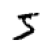

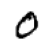

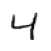

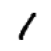

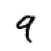

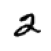

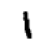

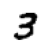

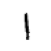

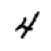

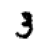

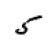

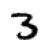

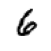

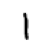

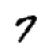

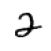

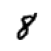

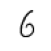

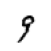

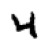

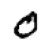

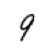

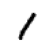

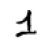

In [5]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(25):
# define subplot
  pyplot.subplot(5, 5, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  pyplot.imshow(trainX[i], cmap='gray_r')
  pyplot.show()

<p>We will use the images in the training dataset as the basis for training a Generative Adversarial
Network. Specifically, the generator model will learn how to generate new plausible handwritten
digits between 0 and 9, using a discriminator that will try to distinguish between real images
from the MNIST training dataset and new images output by the generator model. This is a
relatively simple problem that does not require a sophisticated generator or discriminator model,
although it does require the generation of a grayscale output image.</p>

<h1><font color ='red'>Define and Train the Discriminator Model</font></h1>

<p>The model must take a sample image from
our dataset as input and output a classification prediction as to whether the sample is real or
fake. This is a binary classification problem:</p>
<ul>
<li>Inputs: Image with one channel and 28 × 28 pixels in size.</li>
<li>Outputs: Binary classification, likelihood the sample is real (or fake).</li>

</ul>
</br>

**The details of the network include**
<p>
The discriminator model has two convolutional layers with:
<ul>
<li>64 filters </li>
<li>kernel size of 3</li>
<li>Stride of 2 </li>
<li>No pooling layers </li>
<li>A single node in the output layer with the sigmoid activation function</li>
<li>The model is trained to minimize the binary cross-entropy loss function</li>
<li>We will use ReLU as activate function</li>
<li>Dropout</li>
<li>Adam version of SGD and learning rate of 0.0002woth zero momentum</li>

</ul>
</p>


<h1><font color=black">Define a function to create a the descrimiantor when you want</font></h1>


In [6]:
#define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):

  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [7]:
optimizer = tf.keras.optimizers.Adam()

In [8]:
descriminator=define_discriminator()
descriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

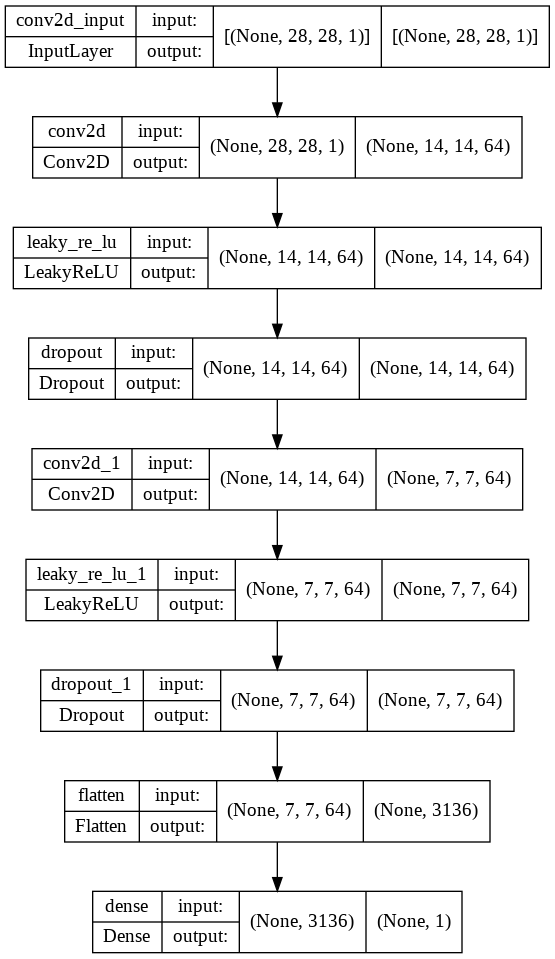

In [9]:
plot_model(descriminator, show_shapes=True, show_layer_names=True)

<h1>Lets do a little experiment</h1>
<p>
We want to see if we generate random images, how well the descriminator can detect real images.
</br>
so this is what we will do:
</p>
<ul>
<li>load and prepare mnist training images</li>
<li>select real samples</li>
<li>generate n fake samples with class labels</li>
</ul>
and finally</br>

# Train the descriminator



In [10]:
#load and prepare mnist training images
def load_real_samples():
  # load mnist dataset
  (trainX, _), (_, _) = load_data()
  # expand to 3d, e.g. add channels dimension
  X = np.expand_dims(trainX, axis=-1)
  # convert from unsigned ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [0,1]
  X = X / 255.0
  return X
# select real samples


In [11]:
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate ✬real✬ class labels (1)
  y = np.ones((n_samples, 1))
  return X, y

In [12]:
def generate_fake_samples(n_samples):
  # generate uniform random numbers in [0,1]
  X = np.random.rand(28 * 28 * n_samples)
  # reshape into a batch of grayscale images
  X = X.reshape((n_samples, 28, 28, 1))
  # generate  ✬fake✬ class labels (0)
  y = np.zeros((n_samples, 1))
  return X, y

In [13]:
def train_discriminator(model, dataset, n_iter=40, n_batch=256):
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_iter):
    # get randomly selected ✬real✬ samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    # update discriminator on real samples
    _, real_acc = model.train_on_batch(X_real, y_real)
    # generate ✬fake✬ examples
    X_fake, y_fake = generate_fake_samples(half_batch)
    # update discriminator on fake samples
    _, fake_acc = model.train_on_batch(X_fake, y_fake)
    # summarize performance
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [14]:
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

>1 real=70% fake=34%
>2 real=73% fake=45%
>3 real=75% fake=69%
>4 real=77% fake=75%
>5 real=74% fake=90%
>6 real=79% fake=95%
>7 real=75% fake=97%
>8 real=76% fake=100%
>9 real=78% fake=100%
>10 real=75% fake=100%
>11 real=80% fake=100%
>12 real=86% fake=100%
>13 real=84% fake=100%
>14 real=84% fake=100%
>15 real=80% fake=100%
>16 real=81% fake=100%
>17 real=84% fake=100%
>18 real=84% fake=100%
>19 real=83% fake=100%
>20 real=86% fake=100%
>21 real=87% fake=100%
>22 real=91% fake=100%
>23 real=97% fake=100%
>24 real=93% fake=100%
>25 real=92% fake=100%
>26 real=96% fake=100%
>27 real=96% fake=100%
>28 real=100% fake=100%
>29 real=98% fake=100%
>30 real=98% fake=100%
>31 real=98% fake=100%
>32 real=99% fake=100%
>33 real=98% fake=100%
>34 real=100% fake=100%
>35 real=99% fake=100%
>36 real=100% fake=100%
>37 real=100% fake=100%
>38 real=99% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%


<h1>Define the Generator Model</h1>

<p>The generator model is responsible for creating new, fake but plausible images of handwritten digits.</p>

<p>It does this by taking a point from the latent space as input and outputting a square grayscale image. </p>

<p>The latent space is an arbitrarily defined vector space of Gaussian-distributed values, e.g. 100 dimensions.</p>
It has no meaning, but by drawing points from this space randomly and providing 

<p>them to the generator model during training, the generator model will assign
meaning to the latent points. </p>

<p>At the end of training, the latent vector space represents a compressed representation of the output space, MNIST images, that only the generator knows
how to turn into plausible MNIST images.</p>

<p1>Model input and outputs are</p>
<ul>
<li>Inputs: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.</li>
<li> Outputs: Two-dimensional square grayscale image of 28 × 28 pixels with pixel values in [0,1].</li>
</ul>

<p>Developing a generator model requires that we transform a vector from the latent space with, 100 dimensions to a 2D array with 28×28 or 784 values. 
</p>


There are a number of ways to achieve this but there is one approach
that has proven effective at deep convolutional generative adversarial networks. It involves two
main elements. The first is a Dense layer as the first hidden layer that has enough nodes to
represent a low-resolution version of the output image. Specifically, an image half the size (one
quarter the area) of the output image would be 14 × 14 or 196 nodes, and an image one quarter
the size (one eighth the area) would be 7 × 7 or 49 nodes.
We don’t just want one low-resolution version of the image; we want many parallel versions
or interpretations of the input. This is a pattern in convolutional neural networks where we
have many parallel filters resulting in multiple parallel activation maps, called feature maps,
with different interpretations of the input. We want the same thing in reverse: many parallel
versions of our output with different learned features that can be collapsed in the output layer
into a final image. The model needs space to invent, create, or generate. Therefore, the first
hidden layer, the Dense layer needs enough nodes for multiple low-resolution versions of our
output image, such as 128.

<h1>Define the standalone generator model</h1>

<p>First, lets generate points in latent space as input for the generator</p>

In [15]:

def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = np.random.randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [16]:
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))
  # upsample to 14x14
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 28x28
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

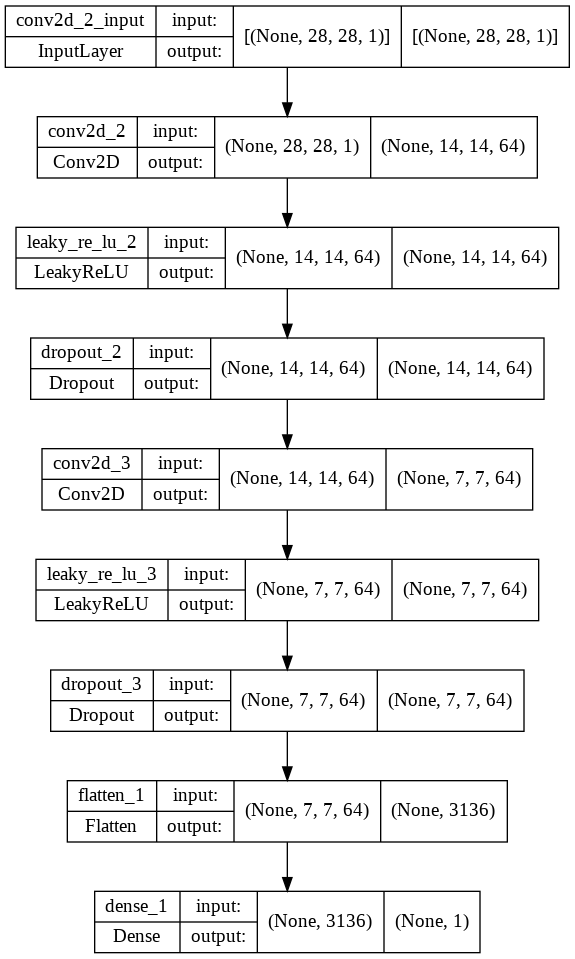

In [17]:
# define the size of the latent space
latent_dim = 100
# define the generator model
generator = define_generator(latent_dim)
# summarize the model
generator.summary()
# plot the model
plot_model(model, show_shapes=True, show_layer_names=True)

<p><font color = 'blue'>Generate fake samples</font></p>
<p>Now we can't do much with this model, because it is not trained.</p>
But if we run the model we expect to get some noisy images with desired size

In [18]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  # create ✬fake✬ class labels (0)
  y = np.zeros((n_samples, 1))
  return X, y

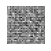

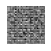

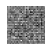

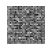

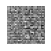

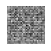

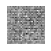

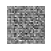

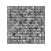

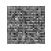

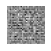

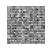

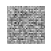

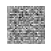

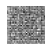

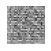

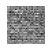

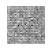

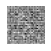

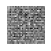

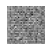

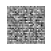

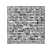

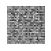

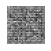

In [19]:
# size of the latent space
latent_dim = 100
# define the discriminator model
generator = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(generator, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
  # define subplot
  pyplot.subplot(5, 5, 1 + i)
  # turn off axis labels
  pyplot.axis('off')
  # plot single image
  pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
  # show the figure
  pyplot.show()

<h1>So far.... </h1>

<ul>
<li>We created a function to sample N points for are latent vector</li>
<li>we created a function to create M samples from the real images dataset</li>
<li>we created a function to create M fake sample useing the Generator architecture</li>
<li>We createed the Generator network</li>
<li>We created the Descriminator network</li>
<li>Now we have to build the GAN model</li>
</ul>

# At training time: 
<ul>
<li> We have to loop N-epochs</li>
<li> In each epoch we have to iterate over all batches</li>
<li> for each batch we have to:<ul> <li>train the descriminator</li> 
<li>Then, with the GAN network in which the descriminator is freexed, train the generator</li>  </ul>
</ul>

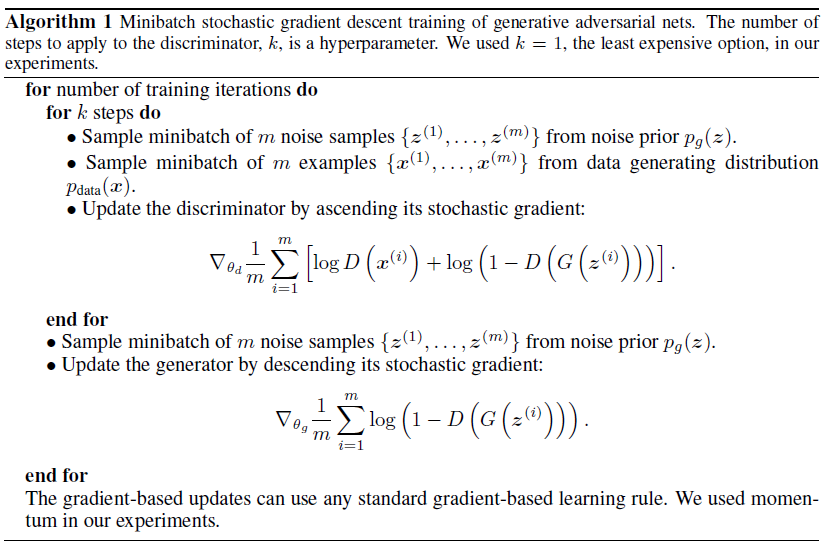

<h1> Frist, lets create the GAN Model</h1>

---




In [20]:

def define_gan(g_model, d_model):
# make weights in the discriminator not trainable
  d_model.trainable = False ############## NOTICE THE FROZED DESCRIMINATOR###############
  # connect them
  model = Sequential()
  # add generator
  model.add(g_model)
  # add the discriminator
  model.add(d_model)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

# lets check our model 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


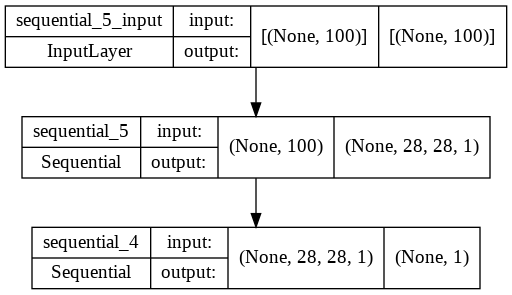

In [21]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model,  show_shapes=True, show_layer_names=True)

In [22]:
#@title Default title text
# # generate points in latent space as input for the generator
# def generate_latent_points(latent_dim, n_samples):
#   # generate points in the latent space
#   x_input = np.random.randn(latent_dim * n_samples)
#   # reshape into a batch of inputs for the network
#   x_input = x_input.reshape(n_samples, latent_dim)
#   return x_input

In [23]:
#@title Default title text
# # use the generator to generate n fake examples, with class labels
# def generate_fake_samples(g_model, latent_dim, n_samples):
#   # generate points in latent space
#   x_input = generate_latent_points(latent_dim, n_samples)
#   # predict outputs
#   X = g_model.predict(x_input)
#   # create ✬fake✬ class labels (0)
#   y = np.zeros((n_samples, 1))
#   return X, y

In [24]:
#@title Default title text
# # train the composite model
# def train_gan(gan_model, latent_dim, n_epochs=10, n_batch=256):
#   # manually enumerate epochs
#   for i in range(n_epochs):
#     # prepare points in latent space as input for the generator
#     x_gan = generate_latent_points(latent_dim, n_batch)
#     # create inverted labels for the fake samples
#     y_gan = np.ones((n_batch, 1))
#     # update the generator via the discriminator✬s error
#     gan_model.train_on_batch(x_gan, y_gan)

<h1> <font color = 'red'> A code to summarize the results </font></h1>

In [25]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%'  % (acc_real*100, acc_fake*100))
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)


In [47]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
  # plot images
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()


<h1><font color='blue'>The training function </font></h1>

In [46]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  print(bat_per_epo)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected ✬real✬ samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate ✬fake✬ examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator✬s error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
  if (i+1) % 3 == 0:
    summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [48]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
dataset = dataset[:10000,:,:,:]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [49]:
np.shape(dataset)

(10000, 28, 28, 1)

In [50]:
train(g_model, d_model, gan_model, dataset, latent_dim)


39
>1, 1/39, d=0.688, g=0.720
>1, 2/39, d=0.682, g=0.738
>1, 3/39, d=0.670, g=0.771
>1, 4/39, d=0.658, g=0.789
>1, 5/39, d=0.652, g=0.819
>1, 6/39, d=0.646, g=0.835
>1, 7/39, d=0.635, g=0.851
>1, 8/39, d=0.628, g=0.868
>1, 9/39, d=0.628, g=0.875
>1, 10/39, d=0.625, g=0.869
>1, 11/39, d=0.630, g=0.854
>1, 12/39, d=0.634, g=0.830
>1, 13/39, d=0.639, g=0.799
>1, 14/39, d=0.641, g=0.771
>1, 15/39, d=0.649, g=0.752
>1, 16/39, d=0.648, g=0.736
>1, 17/39, d=0.640, g=0.725
>1, 18/39, d=0.636, g=0.718
>1, 19/39, d=0.632, g=0.714
>1, 20/39, d=0.623, g=0.710
>1, 21/39, d=0.614, g=0.708
>1, 22/39, d=0.610, g=0.707
>1, 23/39, d=0.596, g=0.706
>1, 24/39, d=0.594, g=0.706
>1, 25/39, d=0.586, g=0.706
>1, 26/39, d=0.569, g=0.706
>1, 27/39, d=0.559, g=0.706
>1, 28/39, d=0.547, g=0.707
>1, 29/39, d=0.543, g=0.707
>1, 30/39, d=0.537, g=0.708
>1, 31/39, d=0.528, g=0.708
>1, 32/39, d=0.514, g=0.709
>1, 33/39, d=0.503, g=0.710
>1, 34/39, d=0.494, g=0.711
>1, 35/39, d=0.485, g=0.712
>1, 36/39, d=0.471, g=0.71

In [53]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
  # plot images
    for i in range(n * n):
      # define subplot
      pyplot.subplot(n, n, 1 + i)
      # turn off axis
      pyplot.axis('off')
      # plot raw pixel data
      pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
      pyplot.show()
      # load model
      model = load_model('generator_model_100.h5')
      # generate images
      latent_points = generate_latent_points(100, 25)
      # generate images
      X = model.predict(latent_points)
      # plot the result
      save_plot(X, 5)

# load model
model = load_model('generator_model_4.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

OSError: ignored